In [477]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import re

In [478]:
fiscal_data = pd.read_csv("Sdf16_1a.txt", sep='\t', low_memory=False)
fiscal_data['LEAID'] = fiscal_data['LEAID'].astype(str)

In [479]:
enrollment_data = pd.read_csv("ccd_lea_052_1516_w_1a_011717.csv", low_memory=False)
enrollment_data['LEAID'] = enrollment_data['LEAID'].astype(str)

### Problem 1

In [480]:
district_data = fiscal_data[["LEAID", "STNAME", "TOTALREV", "TOTALEXP" ]]
district_data = district_data[district_data['TOTALREV']>=0]
district_data = district_data[district_data['TOTALEXP']>=0]

In [481]:
federal_rev = fiscal_data[fiscal_data['TFEDREV'] >= 0]
total_federal_rev = int(federal_rev[['TFEDREV']].sum())
print('Total U.S. federal budget for funding school districts: $',total_federal_rev)
total_amount_cut = int(total_federal_rev*0.15)
print('15% of the U.S. federal budget for funding school districts: $', total_amount_cut)

Total U.S. federal budget for funding school districts: $ 55602742000
15% of the U.S. federal budget for funding school districts: $ 8340411300


In [482]:
debt = district_data.groupby(['LEAID', 'STNAME']).sum().reset_index()
debt['DEBT'] = debt['TOTALEXP'] - debt['TOTALREV']
debt_neg = debt[debt['DEBT'] < 0]
debt_neg.loc[:,'DEBT'] *= -1
total_extra = debt_neg['DEBT'].sum()
total_extra

28234151000

In [483]:
debt_neg.loc[:, 'REV_CUT'] = round((total_amount_cut/total_extra)*(debt_neg['DEBT']))
revenue_cut = debt_neg[['LEAID', 'STNAME', 'REV_CUT', 'TOTALREV']]

In [627]:
revenue_cut.loc[:, 'PROP_REV_CUT'] = revenue_cut.loc[:,'REV_CUT']/revenue_cut.loc[:,'TOTALREV']
revenue_cut.head()

,LEAID,STNAME,REV_CUT,TOTALREV,PROP_REV_CUT
0,0100005,Alabama,891226.0,49795000,0.017898
2,0100007,Alabama,769226.0,168040000,0.004578
3,0100008,Alabama,1409951.0,105927000,0.013311
5,0100012,Alabama,118161.0,22813000,0.005180
7,0100030,Alabama,830669.0,32454000,0.025595


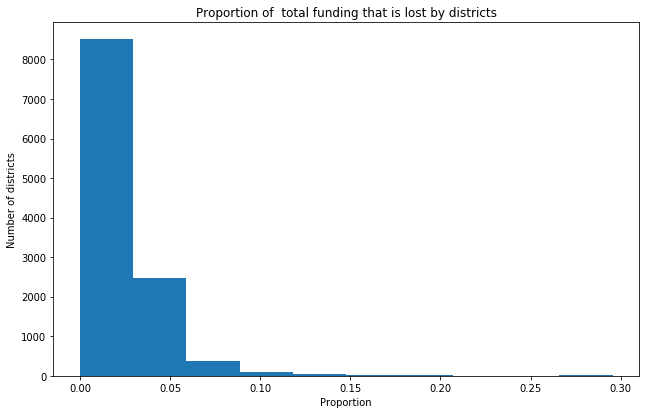

In [486]:
fig = plt.figure()
plt.hist(revenue_cut['PROP_REV_CUT'], bins = 10)
plt.title('Proportion of  total funding that is lost by districts')
plt.xlabel('Proportion')
plt.ylabel('Number of districts')
plt.savefig('budget_cut_proportion')
fig.set_size_inches(10.5, 6.5)
plt.show()

In [487]:
prop_rev_cut = revenue_cut[['LEAID', 'STNAME', 'PROP_REV_CUT']].sort_values(by = ['PROP_REV_CUT'], ascending = False)
prop_rev_cut.head(10)

,LEAID,STNAME,PROP_REV_CUT
14403,4800191,Texas,0.295500
9234,3400059,New Jersey,0.295403
11052,3800395,North Dakota,0.295403
11596,3901570,Ohio,0.295402
14459,4800291,Texas,0.295401
14439,4800261,Texas,0.295401
14347,4800091,Texas,0.295401
2569,09D0001,Connecticut,0.295401
297,0400206,Arizona,0.295401
9242,3400075,New Jersey,0.295401


As shown above, these are top 10 districts which affected the most due to cut in funding.

### Problem 2

In [488]:
races = ['AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR']
enrollment_races = enrollment_data[['LEAID', 'TOTAL','AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR']]

In [534]:
fiscal_rev = pd.merge(fiscal_data, prop_rev_cut, on = ["LEAID"], how = "left")
fiscal_rev.loc[:,'PROP_REV_CUT'] = np.where(pd.isna(fiscal_rev.loc[:,'PROP_REV_CUT']), 0, fiscal_rev.loc[:,'PROP_REV_CUT'])
fiscal_rev.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME_x,STABBR,SCHLEV,...,FL_W01,FL_W31,FL_W61,FL_V95,FL_V02,FL_K14,FL_CE1,FL_CE2,STNAME_y,PROP_REV_CUT
0,0100002,N,1,01073,142,13820,Alabama Youth Services,Alabama,AL,N,...,M,M,M,M,M,M,M,M,NaN,0.000000
1,0100005,01504840100000,1,01095,290,10700,Albertville City,Alabama,AL,03,...,R,R,R,M,M,M,M,M,Alabama,0.017898
2,0100006,01504800100000,1,01095,290,10700,Marshall County,Alabama,AL,03,...,R,R,R,M,M,M,M,M,NaN,0.000000
3,0100007,01503740100000,1,01073,142,13820,Hoover City,Alabama,AL,03,...,R,R,R,M,M,M,M,M,Alabama,0.004578
4,0100008,01504530100000,1,01089,290,26620,Madison City,Alabama,AL,03,...,R,R,R,M,M,M,M,M,Alabama,0.013311


In [538]:
for i in range(len(fiscal_rev)):
    fiscal_rev.loc[i,'LEAID'] = fiscal_rev.loc[i,'LEAID'].strip("0")

In [593]:
fiscal_enroll = pd.merge(fiscal_rev, enrollment_races, on = ["LEAID"], how ='left')
fiscal_enroll.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME_x,STABBR,SCHLEV,...,STNAME_y,PROP_REV_CUT,TOTAL,AM,AS,HI,BL,WH,HP,TR
0,100002,N,1,01073,142,13820,Alabama Youth Services,Alabama,AL,N,...,NaN,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,100005,01504840100000,1,01095,290,10700,Albertville City,Alabama,AL,03,...,Alabama,0.017898,5214.0,14.0,17.0,2289.0,152.0,2619.0,4.0,119.0
2,100006,01504800100000,1,01095,290,10700,Marshall County,Alabama,AL,03,...,NaN,0.000000,5635.0,26.0,17.0,1160.0,50.0,4331.0,2.0,49.0
3,100007,01503740100000,1,01073,142,13820,Hoover City,Alabama,AL,03,...,Alabama,0.004578,13910.0,10.0,931.0,1008.0,3541.0,8131.0,14.0,275.0
4,100008,01504530100000,1,01089,290,26620,Madison City,Alabama,AL,03,...,Alabama,0.013311,10011.0,62.0,862.0,439.0,2042.0,6186.0,27.0,393.0


In [588]:
fiscal_enroll_norevcut = fiscal_enroll[fiscal_enroll['PROP_REV_CUT'] == 0]
fiscal_enroll_revcut = fiscal_enroll[fiscal_enroll['PROP_REV_CUT'] > 0]

In [589]:
races=['AM', 'AS','HI', 'BL', 'WH', 'HP', 'TR', 'TOTAL']
fiscal_enroll_norevcut = fiscal_enroll_norevcut[races].sum()
fiscal_enroll_revcut = fiscal_enroll_revcut[races].sum()
for each_race in races[:-1]:
    fiscal_enroll_norevcut[each_race + '_'] = fiscal_enroll_norevcut[each_race] / fiscal_enroll_norevcut[races[-1]]
    fiscal_enroll_revcut[each_race + '_'] = fiscal_enroll_revcut[each_race] / fiscal_enroll_revcut[races[-1]]

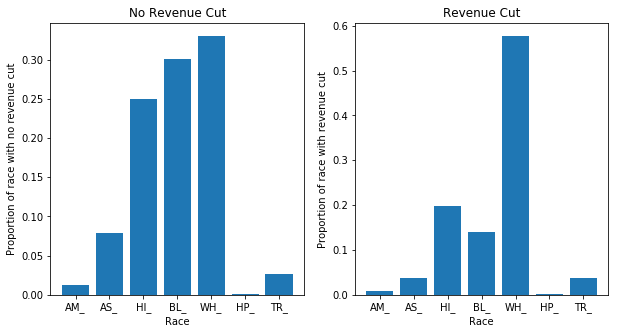

In [591]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.bar(fiscal_enroll_norevcut.index[8:], fiscal_enroll_norevcut[8:])
plt.title('No Revenue Cut')
plt.xlabel('Race')
plt.ylabel('Proportion of race with no revenue cut')
plt.subplot(1, 2, 2)
plt.bar(fiscal_enroll_revcut.index[8:], fiscal_enroll_revcut[8:])
plt.title('Revenue Cut')
plt.xlabel('Race')
plt.ylabel('Proportion of race with revenue cut')
plt.show()

The distributions appear to be different for districts that received budgets cuts and for districts that did not receive any budget cuts based on the races.
As we can see, the distribution of proportion of people recieving revenue cuts for all races are different from proportion of people not receiving budget cuts for all races. We can also see that, based on caste, revenue cuts are not spread out evenly and districts with a large number of people belonging to WH race would have higher chances of receiving a busget cut. This unsimilarity in distribution of proportions shows that there has been bias introduced in calculations which has resulted in these numbers.

### Problem 3

In [614]:
disable_data = pd.read_csv('ccd_lea_002089_1516_w_1a_011717.csv')
disable_data['LEAID'] = disable_data['LEAID'].astype(str)
disable_data.head()

,SURVYEAR,FIPST,STABR,STATENAME,SEANAME,LEAID,ST_LEAID,LEA_NAME,SPECED
0,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100002,210,Alabama Youth Services,24
1,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100005,101,Albertville City,267
2,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100006,048,Marshall County,430
3,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100007,158,Hoover City,861
4,2015-2016,1,AL,ALABAMA,Alabama Department Of Education,100008,169,Madison City,735


In [ ]:
disable_rev = pd.merge(fiscal_rev, disable_data, on='LEAID', how="left")

In [625]:
def disable_cuts(data, rev_cut = True):
    if rev_cut == True:
        df = data[data['PROP_REV_CUT'] > 0]
    else:
        df = data[data['PROP_REV_CUT'] == 0]
    df = df[['V33', 'SPECED']]
    df['NOSPECED'] = df['V33'] - df['SPECED']
    df = df.sum()
    df['NOSPECED_PROP'] = df['NOSPECED'] / df['V33']
    df['SPECEDR_PROP'] = df['SPECED'] / df['V33']
    return df

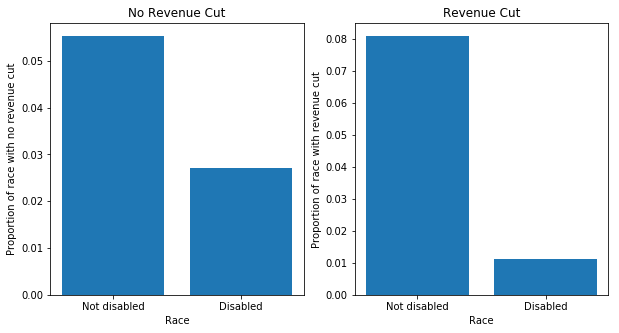

In [626]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.bar(['Not disabled', 'Disabled'], disable_cuts(disable_rev, rev_cut=False)[3:5])
plt.title('No Revenue Cut')
plt.xlabel('Race')
plt.ylabel('Proportion of race with no revenue cut')
plt.subplot(1, 2, 2)
plt.bar(['Not disabled', 'Disabled'], disable_cuts(disable_rev, rev_cut=True)[3:5])
plt.title('Revenue Cut')
plt.xlabel('Race')
plt.ylabel('Proportion of race with revenue cut')
plt.show()

The distributions appear to be the same for districts that received budgets cuts and for districts that did not receive any budget cuts based on the disability factor.
As we can see, the proportion of people who are not disabled and receiving revenue cuts is higher than those not receiving any budget cuts. Also, there are higher proportions of disabled people not receving budget cuts than those which receive budget cuts. This similarity in distribution of proportions shows that there has not been any bias introduced in calculations which has resulted in an unbiased solution.

### Problem 4

I chose Devanshi Gariba's strategy for budget cuts. She has used the idea of not cutting equal amounts from each of the school districts, instead cut revenue according to the proportion of current revenue and expenditure. This is justified because some school districts might earn less and some might earn more. Deduction of equal amount of budget would be unfair to school districts with lower revenue. She also considered only those school districts which have a positive funding after taking into account their revenue and expenditure. This is also a beneficial point and adds to better results. One disadvantage of this method is that only the monitary features were taken into consideration. It might help remove bias if any, by taking additional features like demographics into account.
An additional check she did was to check if the budget cut from different school districts actually add up to how much of a cut is required. This was a well thought of step as it could avoid cutting budgets unnecessarily.

### Problem 5

The most interesting special lecture topic I found was the MapReduce lecture by Jan Vitek. He gave a brief understanding about MapReduce and how it is implemented at a basic level. He also gave light on the history of MapReduce and Big data. It was very informational as big data is the talk of the town. In our coursework, we don not generally get to work with large datasets, whereas almost every big company would have very large datasets to deal with. I understood the need to be aware of such technology and concepts which could help in faster and better processing or big data. Parallelization of processes would also help increase efficiency and is made possible by using MapReduce concepts. 